Setup and Imports

In [1]:
# Complete Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
import os
import random
import h5py
from pathlib import Path
from collections import defaultdict, Counter
from typing import List, Dict, Set, Any, Optional, Tuple

# TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Set paths
DATA_PATH = Path("../data/sample/usegalaxy_workflow_connections_2026-02-11_10-48-58.tsv")
PROJECT_ROOT = Path("..")
OUTPUT_DIR = Path("../models/transformer_tool_recommendation")
PROCESSED_DIR = Path("../data/processed")

# Create directories
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)
PROCESSED_DIR.mkdir(exist_ok=True, parents=True)

2026-02-25 22:58:50.634229: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Data Loading and Initial Exploration

In [36]:
print("Loading Neo4j workflow connections...")
df = pd.read_csv(DATA_PATH, sep='\t')

print(f"Dataset shape: {df.shape}")
print(f"Unique workflows: {df['workflow_id'].nunique()}")
print(f"Unique source tools: {df['source_tool'].nunique()}")
print(f"Unique target tools: {df['target_tool'].nunique()}")


display(df.head())
print(df.info())

workflow_stats = df.groupby('workflow_id').agg({
    'source_step_id': 'count',
    'source_tool': 'nunique'
}).rename(columns={'source_step_id': 'num_connections', 'source_tool': 'unique_tools'})


Loading Neo4j workflow connections...
Dataset shape: (48598, 11)
Unique workflows: 2189
Unique source tools: 1437
Unique target tools: 1849


,workflow_id,workflow_name,created_at,source_step_id,source_tool,source_tool_version,source_output_name,target_step_id,target_tool,target_tool_version,target_input_name
0,b65280467af44ffd,16S Microbial analysis with Nanopore data (Final),2026-02-04T18:54:40.389712,0,Input,NaN,output,1,toolshed.g2.bx.psu.edu/repos/devteam/fastqc/fa...,0.74+galaxy1,input_file
1,b65280467af44ffd,16S Microbial analysis with Nanopore data (Final),2026-02-04T18:54:40.389712,0,Input,NaN,output,2,toolshed.g2.bx.psu.edu/repos/iuc/porechop/pore...,0.2.4+galaxy1,input_file
2,b65280467af44ffd,16S Microbial analysis with Nanopore data (Final),2026-02-04T18:54:40.389712,1,toolshed.g2.bx.psu.edu/repos/devteam/fastqc/fa...,0.74+galaxy1,text_file,3,toolshed.g2.bx.psu.edu/repos/iuc/multiqc/multi...,1.33+galaxy0,results_0|software_cond|output_0|input
3,b65280467af44ffd,16S Microbial analysis with Nanopore data (Final),2026-02-04T18:54:40.389712,2,toolshed.g2.bx.psu.edu/repos/iuc/porechop/pore...,0.2.4+galaxy1,outfile,4,toolshed.g2.bx.psu.edu/repos/iuc/fastp/fastp/1...,1.1.0+galaxy0,single_paired|in1
4,b65280467af44ffd,16S Microbial analysis with Nanopore data (Final),2026-02-04T18:54:40.389712,4,toolshed.g2.bx.psu.edu/repos/iuc/fastp/fastp/1...,1.1.0+galaxy0,out1,5,toolshed.g2.bx.psu.edu/repos/devteam/fastqc/fa...,0.74+galaxy1,input_file


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48598 entries, 0 to 48597
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   workflow_id          48598 non-null  object
 1   workflow_name        48598 non-null  object
 2   created_at           48598 non-null  object
 3   source_step_id       48598 non-null  int64 
 4   source_tool          48598 non-null  object
 5   source_tool_version  31742 non-null  object
 6   source_output_name   48598 non-null  object
 7   target_step_id       48598 non-null  int64 
 8   target_tool          48598 non-null  object
 9   target_tool_version  43605 non-null  object
 10  target_input_name    48598 non-null  object
dtypes: int64(2), object(9)
memory usage: 4.1+ MB
None


Tool ID Cleaning and Standardization

In [37]:
import re
import pandas as pd

MAX_LEN = 25
CONTEXT_KEY_LENGTH = MAX_LEN

def is_input_node(tool_id: str) -> bool:
    if pd.isna(tool_id):
        return False
    value = str(tool_id).strip().lower()
    if value == "input":
        return True
    return value.startswith("input dataset") or value.startswith("input parameter") or value.startswith("input collection")

def is_parameter_node(tool_id: str) -> bool:
    if pd.isna(tool_id):
        return False
    value = str(tool_id).strip().lower()
    return value.startswith("input parameter")

def is_non_tool_label(tool_id: str, version: str) -> bool:
    if pd.isna(tool_id):
        return True
    version_value = str(version).strip().lower() if not pd.isna(version) else ""
    if version_value == "n/a":
        value = str(tool_id).strip()
        if " " in value and not is_input_node(value):
            return True
    return False

def clean_tool_id(tool_id: str) -> str:
    """
    Clean tool identifiers while preserving real tool identity.
    Avoid over-collapsing valid tool names.
    """
    if pd.isna(tool_id):
        return "<UNK>"
    tool_id = str(tool_id).strip()
    if is_input_node(tool_id):
        return "<INPUT_DATA>"
    if re.fullmatch(r"[a-f0-9]{32}", tool_id):
        return f"tool_{tool_id}"
    if "/" in tool_id:
        parts = tool_id.split("/")
        if len(parts) >= 2:
            tool_name = parts[-2]
        else:
            tool_name = parts[-1]
    else:
        tool_name = tool_id
    tool_name = re.sub(r"[^a-zA-Z0-9_]", "_", tool_name)
    tool_name = re.sub(r"_+", "_", tool_name).strip("_")
    return tool_name.lower() if tool_name else "unknown_tool"

rows_before = len(df)
source_param = df["source_tool"].apply(is_parameter_node)
target_param = df["target_tool"].apply(is_parameter_node)
source_version = df["source_tool_version"] if "source_tool_version" in df.columns else pd.Series(["n/a"] * len(df), index=df.index)
target_version = df["target_tool_version"] if "target_tool_version" in df.columns else pd.Series(["n/a"] * len(df), index=df.index)
source_non_tool = df.apply(lambda row: is_non_tool_label(row["source_tool"], source_version.loc[row.name]), axis=1)
target_non_tool = df.apply(lambda row: is_non_tool_label(row["target_tool"], target_version.loc[row.name]), axis=1)
target_input = df["target_tool"].apply(is_input_node)
drop_mask = source_param | target_param | source_non_tool | target_non_tool | target_input
df = df.loc[~drop_mask].copy()

df["source_tool_clean"] = df["source_tool"].apply(clean_tool_id)
df["target_tool_clean"] = df["target_tool"].apply(clean_tool_id)

version_cols = [col for col in ["source_tool_version", "target_tool_version"] if col in df.columns]
if version_cols:
    df = df.drop(columns=version_cols)
    print("Version columns dropped to prevent leakage.")
else:
    print("No version columns found; skipping drop.")

all_tools = set(df["source_tool_clean"]) | set(df["target_tool_clean"])
tool2id = {tool: idx for idx, tool in enumerate(sorted(all_tools))}
id2tool = {idx: tool for tool, idx in tool2id.items()}

input_count = (df["source_tool_clean"] == "<INPUT_DATA>").sum()

print("Top source tools:")
print(df["source_tool_clean"].value_counts().head(10))

print("Top target tools:")
print(df["target_tool_clean"].value_counts().head(10))

Version columns dropped to prevent leakage.
Top source tools:
source_tool_clean
<INPUT_DATA>             13471
macs2_callpeak            1605
samtool_filter2           1468
trimmomatic               1258
cut1                      1188
picard_markduplicates     1138
param_value_from_file      927
bowtie2                    917
cutadapt                   913
filter1                    847
Name: count, dtype: int64
Top target tools:
target_tool_clean
multiqc                  2242
fastqc                   2045
gfastats                 1638
macs2_callpeak           1284
cut1                     1190
filter1                  1183
bowtie2                   980
cutadapt                  912
bwa_mem                   863
param_value_from_file     737
Name: count, dtype: int64


Workflow Sequence Generation

In [38]:
# Cell 4: Corrected and Optimized Workflow Sequence Builder
import networkx as nx

def build_workflow_sequences_corrected(workflow_df, min_seq_length=2, max_seq_length=25, max_paths_per_workflow=5000):
    """
    Build workflow sequences from DAGs with optimizations to prevent explosion.

    Features:
    - Preserves DAG branching.
    - Extracts root-to-leaf paths.
    - Converts step IDs to cleaned tools.
    - Removes consecutive duplicate tools.
    - Generates prefix sequences up to max_seq_length.
    - Limits total sequences per workflow for efficiency.
    """
    print("🔧 Building workflow sequences (corrected DAG method)...")

    sequences = []
    workflow_stats = []

    for workflow_id, group in workflow_df.groupby("workflow_id"):
        # Build DAG
        G = nx.DiGraph()
        step_to_tool = {}

        for _, row in group.iterrows():
            s_id = str(row["source_step_id"])
            t_id = str(row["target_step_id"])
            s_tool = row["source_tool_clean"]
            t_tool = row["target_tool_clean"]

            G.add_edge(s_id, t_id)
            step_to_tool[s_id] = s_tool
            step_to_tool[t_id] = t_tool

        roots = [n for n in G.nodes if G.in_degree(n) == 0]
        leaves = [n for n in G.nodes if G.out_degree(n) == 0]

        workflow_sequence_count = 0

        # Extract paths with limits
        for root in roots:
            for leaf in leaves:
                try:
                    paths = nx.all_simple_paths(G, source=root, target=leaf)
                    for path_idx, path in enumerate(paths):
                        if path_idx >= max_paths_per_workflow:
                            break

                        # Map step IDs to tools
                        tool_sequence = [step_to_tool.get(n, "unknown_tool") for n in path]

                        # Remove consecutive duplicates
                        dedup_sequence = [tool for i, tool in enumerate(tool_sequence)
                                          if i == 0 or tool != tool_sequence[i-1]]

                        # Generate prefix sequences
                        for seq_len in range(min_seq_length, min(len(dedup_sequence), max_seq_length) + 1):
                            prefix_seq = dedup_sequence[:seq_len]
                            sequences.append(prefix_seq)
                            workflow_sequence_count += 1
                except nx.NetworkXNoPath:
                    continue

        workflow_stats.append({
            "workflow_id": workflow_id,
            "sequences_created": workflow_sequence_count,
            "connections": len(group),
            "nodes": len(G.nodes)
        })

    total_sequences = sum(stat["sequences_created"] for stat in workflow_stats)
    utilization = total_sequences / len(workflow_stats)

    print(f"📈 Corrected Workflow Sequence Building Complete")
    print(f"  Workflows processed: {len(workflow_stats)}")
    print(f"  Sequences generated: {total_sequences}")
    print(f"  Average sequences per workflow: {utilization:.1f}")

    return sequences, workflow_stats

# Apply corrected sequence builder
sequences, workflow_stats = build_workflow_sequences_corrected(
    df,
    min_seq_length=2,
    max_seq_length=25,
    max_paths_per_workflow=5000  # prevents combinatorial explosion
)

🔧 Building workflow sequences (corrected DAG method)...
📈 Corrected Workflow Sequence Building Complete
  Workflows processed: 2186
  Sequences generated: 371225
  Average sequences per workflow: 169.8


Vocabulary Creation with Frequency Analysis

In [39]:
# Cell 5: Vocabulary Creation (Paper-Aligned)
from collections import Counter
import numpy as np

def create_vocabulary_paper(sequences, min_frequency=3):
    """
    Create vocabulary according to paper methodology:

    - Uses already cleaned sequences.
    - Filters rare tools based on min_frequency.
    - Adds special tokens: <PAD>, <UNK>, <INPUT_DATA>.
    - Computes vocabulary and sequence statistics.
    """
    print("🔧 Creating vocabulary (paper-aligned)...")

    # Flatten all tools
    all_tools = [tool for seq in sequences for tool in seq]
    tool_counts = Counter(all_tools)
    print(f"📊 Original tool count: {len(tool_counts)}")

    # Keep special tokens regardless of frequency
    special_tokens = ["<PAD>", "<UNK>", "<INPUT_DATA>"]

    # Filter tools by minimum frequency
    filtered_tools = {tool: count for tool, count in tool_counts.items()
                      if count >= min_frequency or tool in special_tokens}
    print(f"📊 Filtered tool count (min_freq={min_frequency}): {len(filtered_tools)}")

    # Build vocabulary: special tokens first, then descending frequency
    vocab_list = special_tokens + [
        tool for tool, _ in sorted(filtered_tools.items(), key=lambda x: x[1], reverse=True)
        if tool not in special_tokens
    ]
    vocab = {tool: idx for idx, tool in enumerate(vocab_list)}
    reverse_vocab = {idx: tool for tool, idx in vocab.items()}

    # Frequency distribution
    freq_dist = {
        'very_rare': len([t for t, c in filtered_tools.items() if t not in special_tokens and c <= 5]),
        'rare': len([t for t, c in filtered_tools.items() if t not in special_tokens and 6 <= c <= 20]),
        'medium': len([t for t, c in filtered_tools.items() if t not in special_tokens and 21 <= c <= 100]),
        'frequent': len([t for t, c in filtered_tools.items() if t not in special_tokens and c > 100])
    }

    # Most common tools (excluding special tokens)
    most_common_tools = [item for item in sorted(filtered_tools.items(), key=lambda x: x[1], reverse=True)
                         if item[0] not in special_tokens][:10]

    # Sequence statistics
    input_sequences = [seq for seq in sequences if "<INPUT_DATA>" in seq]
    avg_seq_len = np.mean([len(seq) for seq in sequences])

    vocab_stats = {
        'total_vocab_size': len(vocab),
        'unique_tools': len(filtered_tools),
        'special_tokens': len(special_tokens),
        'input_data_index': vocab.get('<INPUT_DATA>', -1),
        'input_data_count': filtered_tools.get('<INPUT_DATA>', 0),
        'min_frequency': min_frequency,
        'frequency_distribution': freq_dist,
        'most_common_tools': most_common_tools,
        'total_sequences': len(sequences),
        'sequences_with_input': len(input_sequences),
        'avg_sequence_length': avg_seq_len
    }

    # Print statistics
    print("\n📌 VOCABULARY STATISTICS")
    print(f"  Total vocabulary size: {vocab_stats['total_vocab_size']}")
    print(f"  Unique tools: {vocab_stats['unique_tools']}")
    print(f"  Special tokens: {vocab_stats['special_tokens']}")
    print(f"  <INPUT_DATA> token index: {vocab_stats['input_data_index']}")
    print(f"  <INPUT_DATA> occurrences: {vocab_stats['input_data_count']}")
    print(f"  Minimum frequency used: {min_frequency}")

    print("\n📊 FREQUENCY DISTRIBUTION")
    total_filtered = len(filtered_tools) - len(special_tokens)
    for category, count in freq_dist.items():
        print(f"  {category.capitalize()}: {count} ({count/total_filtered*100:.1f}%)")

    print("\n🔥 TOP 5 MOST COMMON TOOLS")
    for i, (tool, count) in enumerate(most_common_tools[:5], start=1):
        print(f"  {i}. {tool}: {count}")

    print("\n📈 SEQUENCE STATISTICS")
    print(f"  Total sequences: {vocab_stats['total_sequences']}")
    print(f"  Sequences with <INPUT_DATA>: {vocab_stats['sequences_with_input']} "
          f"({vocab_stats['sequences_with_input']/vocab_stats['total_sequences']*100:.1f}%)")
    print(f"  Average sequence length: {vocab_stats['avg_sequence_length']:.2f}")

    return vocab, reverse_vocab, filtered_tools, vocab_stats

# Apply paper-aligned vocabulary creation
vocab, reverse_vocab, tool_counts, vocab_stats = create_vocabulary_paper(sequences, min_frequency=3)

🔧 Creating vocabulary (paper-aligned)...
📊 Original tool count: 875
📊 Filtered tool count (min_freq=3): 815

📌 VOCABULARY STATISTICS
  Total vocabulary size: 817
  Unique tools: 815
  Special tokens: 3
  <INPUT_DATA> token index: 2
  <INPUT_DATA> occurrences: 362743
  Minimum frequency used: 3

📊 FREQUENCY DISTRIBUTION
  Very_rare: 54 (6.7%)
  Rare: 156 (19.2%)
  Medium: 218 (26.8%)
  Frequent: 386 (47.5%)

🔥 TOP 5 MOST COMMON TOOLS
  1. pick_value: 75365
  2. cut1: 67301
  3. gfastats: 56647
  4. cutadapt: 55338
  5. mothur_screen_seqs: 49938

📈 SEQUENCE STATISTICS
  Total sequences: 371225
  Sequences with <INPUT_DATA>: 362743 (97.7%)
  Average sequence length: 5.96


In [40]:
MIN_TOOL_FREQUENCY = 3  # Only include tools appearing ≥3 times
SPECIAL_TOKENS = ["<PAD>", "<UNK>", "<INPUT_DATA>"]

def filter_vocabulary_by_frequency(vocab, tool_counts, min_freq=MIN_TOOL_FREQUENCY, special_tokens=SPECIAL_TOKENS):
    """Filter vocabulary to reduce extreme imbalance (paper-aligned)"""
    
    filtered_vocab = {}
    filtered_tool_counts = {}
    
    # Keep special tokens + tools with frequency ≥ min_freq
    for tool, idx in vocab.items():
        count = tool_counts.get(tool, 0)
        if tool in special_tokens or count >= min_freq:
            filtered_vocab[tool] = idx
            filtered_tool_counts[tool] = count
    
    # Frequency distribution
    freq_dist = {
        'very_rare': len([t for t, c in filtered_tool_counts.items() if t not in special_tokens and c <= 5]),
        'rare': len([t for t, c in filtered_tool_counts.items() if t not in special_tokens and 5 < c <= 20]),
        'medium': len([t for t, c in filtered_tool_counts.items() if t not in special_tokens and 20 < c <= 100]),
        'frequent': len([t for t, c in filtered_tool_counts.items() if t not in special_tokens and c > 100])
    }
    
    # Vocabulary stats
    vocab_stats = {
        'total_tools': len(filtered_vocab),
        'special_tokens': len([t for t in filtered_vocab if t in special_tokens]),
        'unique_tools': len([t for t in filtered_vocab if t not in special_tokens]),
        'input_data_token': '<INPUT_DATA>' in filtered_vocab,
        'input_data_index': filtered_vocab.get('<INPUT_DATA>', -1),
        'most_common': Counter(filtered_tool_counts).most_common(10),
        'frequency_distribution': freq_dist
    }
    
    # Print summary
    print(f"📊 Filtered Vocabulary Statistics:")
    print(f"  Total vocabulary size: {vocab_stats['total_tools']}")
    print(f"  Unique tools (excluding special): {vocab_stats['unique_tools']}")
    print(f"  Special tokens: {vocab_stats['special_tokens']}")
    if vocab_stats['input_data_token']:
        print(f"  Input data token index: {vocab_stats['input_data_index']}")
    print(f"  Most common tools: {vocab_stats['most_common']}")
    print(f"  Frequency distribution: {vocab_stats['frequency_distribution']}")
    
    return vocab, filtered_tool_counts, vocab_stats

Extract Valid Tool Connections

In [41]:
# Cell 6: Compatible Tools Extraction with Clean Sequences (Paper-aligned)
from collections import defaultdict, Counter
import numpy as np
from typing import List, Dict, Tuple

def extract_compatible_tools(sequences: List[List[str]], vocab: Dict[str, int]) -> Tuple[Dict[str, List[str]], Dict[str, any]]:
    """
    Extract all possible next tools for each tool in the cleaned sequences.

    Args:
        sequences: List of sequences (each sequence is a list of cleaned tool IDs)
        vocab: Vocabulary dictionary mapping tools to indices

    Returns:
        compatible_tools: Dict mapping each tool to a list of possible next tools
        connection_stats: Summary statistics for compatible tool connections
    """
    compatible_tools = defaultdict(set)
    tool_pairs_counter = Counter()

    print("🔍 Extracting compatible tools from cleaned sequences...")

    for seq in sequences:
        for i in range(len(seq) - 1):
            current_tool = seq[i]
            next_tool = seq[i + 1]

            # Only consider tools present in the vocabulary
            if current_tool in vocab and next_tool in vocab:
                compatible_tools[current_tool].add(next_tool)
                tool_pairs_counter[f"{current_tool}->{next_tool}"] += 1

    # Convert sets to lists for consistency
    compatible_tools = {tool: sorted(list(next_tools)) for tool, next_tools in compatible_tools.items()}

    # Connection statistics
    next_tools_counts = [len(tools) for tools in compatible_tools.values()]
    connection_stats = {
        'total_tools_with_connections': len(compatible_tools),
        'avg_next_tools_per_tool': np.mean(next_tools_counts) if next_tools_counts else 0,
        'max_next_tools': max(next_tools_counts) if next_tools_counts else 0,
        'min_next_tools': min(next_tools_counts) if next_tools_counts else 0,
        'total_unique_pairs': len(tool_pairs_counter),
        'most_common_pairs': tool_pairs_counter.most_common(10)
    }

    # Print summary
    print("📊 COMPATIBLE TOOLS ANALYSIS:")
    print(f"  Tools with connections: {connection_stats['total_tools_with_connections']}")
    print(f"  Average next tools per tool: {connection_stats['avg_next_tools_per_tool']:.2f}")
    print(f"  Max next tools: {connection_stats['max_next_tools']}")
    print(f"  Min next tools: {connection_stats['min_next_tools']}")
    print(f"  Total unique pairs: {connection_stats['total_unique_pairs']}")
    print(f"  Most common connections:")
    for i, (pair, count) in enumerate(connection_stats['most_common_pairs'][:5]):
        print(f"   {i+1}. {pair}: {count}")

    return compatible_tools, connection_stats

# Extract compatible tools using the cleaned sequences and filtered vocabulary
compatible_tools, connection_stats = extract_compatible_tools(sequences, vocab)

🔍 Extracting compatible tools from cleaned sequences...
📊 COMPATIBLE TOOLS ANALYSIS:
  Tools with connections: 652
  Average next tools per tool: 5.30
  Max next tools: 455
  Min next tools: 1
  Total unique pairs: 3453
  Most common connections:
   1. <INPUT_DATA>->cutadapt: 49728
   2. hifiasm->gfastats: 32948
   3. mothur_screen_seqs->mothur_unique_seqs: 26294
   4. <INPUT_DATA>->mothur_make_contigs: 26242
   5. add_a_column1->cut1: 26221


Multi-Label Target Creation

In [42]:
# Cell X: Paper-aligned Multi-Label Target Creation
def create_multi_label_targets_paper(sequences, vocab, compatible_tools, max_context_length=MAX_LEN, context_key_length=CONTEXT_KEY_LENGTH):
    """
    Create multi-label targets fully aligned with the paper.

    Parameters:
    - sequences: list of sequences of cleaned tools
    - vocab: dict of valid tools
    - compatible_tools: dict of compatible successors for each tool
    - max_context_length: maximum context to consider for input
    - context_key_length: number of last tools to use in context key

    Returns:
    - input_target_pairs: dict mapping context_key -> list of possible next tools
    - target_statistics: Counter of how often each tool appears as target
    """
    input_target_pairs = defaultdict(set)
    target_statistics = Counter()

    print("Creating multi-label targets (paper-aligned)...")

    for seq in sequences:
        seq_len = len(seq)
        for i in range(1, seq_len):
            context = seq[max(0, i - max_context_length):i]
            current_tool = seq[i]

            if current_tool not in vocab:
                continue

            context_key = "|".join(context[-context_key_length:])
            valid_next_tools = compatible_tools.get(context[-1], []) if context else [current_tool]
            if current_tool not in valid_next_tools:
                continue

            input_target_pairs[context_key].add(current_tool)
            target_statistics[current_tool] += 1

    input_target_pairs = {k: list(v) for k, v in input_target_pairs.items()}

    total_contexts = len(input_target_pairs)
    total_targets = sum(len(v) for v in input_target_pairs.values())
    print("Multi-label target creation complete")
    print(f"  Total unique contexts: {total_contexts}")
    print(f"  Total context-target pairs: {total_targets}")
    print(f"  Top 5 most common targets: {target_statistics.most_common(5)}")

    return input_target_pairs, target_statistics

# Apply the paper-aligned target creation
input_target_pairs, target_stats = create_multi_label_targets_paper(
    sequences, vocab, compatible_tools, max_context_length=MAX_LEN, context_key_length=CONTEXT_KEY_LENGTH
)

Creating multi-label targets (paper-aligned)...
Multi-label target creation complete
  Total unique contexts: 11265
  Total context-target pairs: 17029
  Top 5 most common targets: [('pick_value', 75365), ('cut1', 67136), ('gfastats', 56647), ('cutadapt', 55311), ('mothur_screen_seqs', 49938)]


Negative Sampling

In [43]:
# Cell 9: Paper-aligned Negative Sampling and Combination
import random
from collections import defaultdict, Counter

def create_negative_samples_paper(input_target_pairs, compatible_tools, vocab, negative_ratio=1.5):
    """
    Generate negative samples for multi-label workflow prediction.

    - For each context, sample tools NOT compatible with the last tool.
    - Avoid using context tools themselves as negatives.
    - Ensure negative:positive ratio ~= negative_ratio.
    - Special tokens are excluded from negatives.
    """
    print(f"Creating negative samples with 1:{negative_ratio} ratio...")

    all_tools = set(vocab.keys()) - {"<PAD>", "<UNK>", "<INPUT_DATA>"}
    negative_pairs = {}
    total_positive_targets = 0

    for context_str, positives in input_target_pairs.items():
        context_tools = context_str.split("|")
        if not context_tools:
            continue

        total_positive_targets += len(positives)
        last_tool = context_tools[-1]
        valid_next_tools = set(compatible_tools.get(last_tool, []))
        candidate_negatives = list(all_tools - valid_next_tools - set(context_tools))
        num_negatives = max(int(len(positives) * negative_ratio), 1)

        if len(candidate_negatives) >= num_negatives:
            sampled_negatives = random.sample(candidate_negatives, num_negatives)
        else:
            sampled_negatives = candidate_negatives

        if sampled_negatives:
            negative_pairs[context_str] = sampled_negatives

    total_negatives = sum(len(v) for v in negative_pairs.values())
    avg_negatives = total_negatives / total_positive_targets if total_positive_targets > 0 else 0
    print("Negative sampling complete:")
    print(f"  Total positives: {total_positive_targets}")
    print(f"  Total negatives: {total_negatives}")
    print(f"  Achieved ratio: 1:{avg_negatives:.2f}")
    print(f"  Average negatives per positive: {avg_negatives:.2f}")

    return negative_pairs

def combine_positive_negative_pairs(input_target_pairs, negative_pairs):
    """
    Combine positive and negative samples into a unified dictionary.

    Output format:
    {context_str: {"positive": [...], "negative": [...]}}
    """
    print("Combining positive and negative samples...")

    combined_pairs = {}
    total_positives = 0
    total_negatives = 0

    for context, positives in input_target_pairs.items():
        combined_pairs[context] = {"positive": positives, "negative": []}
        total_positives += len(positives)

    for context, negatives in negative_pairs.items():
        if context in combined_pairs:
            combined_pairs[context]["negative"] = negatives
        else:
            combined_pairs[context] = {"positive": [], "negative": negatives}
        total_negatives += len(negatives)

    final_ratio = total_negatives / total_positives if total_positives > 0 else 0

    print("Combined dataset statistics:")
    print(f"  Total contexts: {len(combined_pairs)}")
    print(f"  Total positives: {total_positives}")
    print(f"  Total negatives: {total_negatives}")
    print(f"  Final negative:positive ratio: 1:{final_ratio:.2f}")

    return combined_pairs

# Create paper-aligned negative samples
negative_pairs_3 = create_negative_samples_paper(
    input_target_pairs, compatible_tools, vocab, negative_ratio=1.5
)

# Combine positives and negatives
combined_pairs_3 = combine_positive_negative_pairs(input_target_pairs, negative_pairs_3)

Creating negative samples with 1:1.5 ratio...
Negative sampling complete:
  Total positives: 17029
  Total negatives: 20685
  Achieved ratio: 1:1.21
  Average negatives per positive: 1.21
Combining positive and negative samples...
Combined dataset statistics:
  Total contexts: 11265
  Total positives: 17029
  Total negatives: 20685
  Final negative:positive ratio: 1:1.21


Matrix Creation with Padding

In [44]:
# Cell 10: Paper-Aligned Training Matrix Creation
import numpy as np

USE_COMPATIBLE_TARGETS = True
def create_training_matrices_paper(combined_pairs, vocab, max_len=MAX_LEN, compatible_tools=None, include_compatible_targets=False):
    """
    Convert combined positive/negative samples to training matrices for multi-label workflow prediction.

    - Context sequences are encoded with clean vocabulary.
    - Left-padded to fixed length.
    - Positive targets are multi-hot encoded.
    - Optionally expand positives using compatible tools for the last context tool (paper approach).
    - Negative targets are tracked but not encoded (used for contrastive/explicit negative training).
    - Computes enhanced matrix statistics for validation.
    """
    print("Creating training matrices (paper-aligned)...")

    pad_idx = vocab["<PAD>"]
    unk_idx = vocab["<UNK>"]
    vocab_size = len(vocab)

    X_data, y_data, sample_info = [], [], []

    for context_str, sample in combined_pairs.items():
        context_tools = context_str.split("|")
        valid_context = [tool for tool in context_tools if tool in vocab]
        encoded_context = [vocab.get(tool, unk_idx) for tool in valid_context]
        if len(encoded_context) < max_len:
            encoded_context = [pad_idx] * (max_len - len(encoded_context)) + encoded_context
        else:
            encoded_context = encoded_context[-max_len:]

        target_vector = np.zeros(vocab_size, dtype=np.float32)
        for target_tool in sample["positive"]:
            if target_tool in vocab:
                target_vector[vocab[target_tool]] = 1.0

        if include_compatible_targets and compatible_tools and valid_context:
            last_tool = valid_context[-1]
            for next_tool in compatible_tools.get(last_tool, []):
                if next_tool in vocab:
                    target_vector[vocab[next_tool]] = 1.0

        X_data.append(encoded_context)
        y_data.append(target_vector)
        sample_info.append({
            "context_length": len(valid_context),
            "num_positives": len(sample["positive"]),
            "num_negatives": len(sample["negative"])
        })

    X_data = np.array(X_data, dtype=np.int32)
    y_data = np.array(y_data, dtype=np.float32)

    matrix_stats = {
        "input_shape": X_data.shape,
        "target_shape": y_data.shape,
        "vocab_size": vocab_size,
        "avg_targets_per_sample": np.mean(np.sum(y_data, axis=1)),
        "max_targets_per_sample": np.max(np.sum(y_data, axis=1)),
        "avg_context_length": np.mean([s["context_length"] for s in sample_info]),
        "avg_positives_per_sample": np.mean([s["num_positives"] for s in sample_info]),
        "avg_negatives_per_sample": np.mean([s["num_negatives"] for s in sample_info]),
        "padding_ratio": np.mean(np.sum(X_data == pad_idx, axis=1) / max_len)
    }

    print("Training matrices created")
    print(f"  Input matrix shape: {matrix_stats['input_shape']}")
    print(f"  Target matrix shape: {matrix_stats['target_shape']}")
    print(f"  Vocabulary size: {matrix_stats['vocab_size']}")
    print(f"  Average targets per sample: {matrix_stats['avg_targets_per_sample']:.2f}")
    print(f"  Max targets per sample: {matrix_stats['max_targets_per_sample']}")
    print(f"  Average context length: {matrix_stats['avg_context_length']:.2f}")
    print(f"  Average positives per sample: {matrix_stats['avg_positives_per_sample']:.2f}")
    print(f"  Average negatives per sample: {matrix_stats['avg_negatives_per_sample']:.2f}")
    print(f"  Padding ratio: {matrix_stats['padding_ratio']:.2f}")

    assert y_data.shape[1] == vocab_size, "Target matrix column mismatch with vocab size"

    return X_data, y_data, matrix_stats, sample_info

# Create matrices using paper-aligned function
X_data, y_data, matrix_stats, sample_info = create_training_matrices_paper(
    combined_pairs_3, vocab, max_len=MAX_LEN, compatible_tools=compatible_tools, include_compatible_targets=USE_COMPATIBLE_TARGETS
)
label_counts = np.sum(y_data, axis=0)
print(f"Label counts computed: {label_counts.shape}")

Creating training matrices (paper-aligned)...
Training matrices created
  Input matrix shape: (11265, 25)
  Target matrix shape: (11265, 817)
  Vocabulary size: 817
  Average targets per sample: 13.35
  Max targets per sample: 455.0
  Average context length: 8.58
  Average positives per sample: 1.51
  Average negatives per sample: 1.84
  Padding ratio: 0.66
Label counts computed: (817,)


Class Weighting for Imbalanced Tools

In [45]:
# Cell 11: Class Weights Calculation (Paper-Aligned)
def calculate_class_weights_paper(label_counts, vocab, boost_factor=3.0):
    """
    Calculate class weights for multi-label workflow prediction.

    - Covers all tools in vocabulary.
    - Special tokens have predefined low weights.
    - Rare tools are boosted logarithmically.
    - Aligns with the paper's weighting strategy.
    """
    class_weights = {}

    class_weights[vocab["<PAD>"]] = 0.0
    class_weights[vocab["<UNK>"]] = 0.0
    if "<INPUT_DATA>" in vocab:
        class_weights[vocab["<INPUT_DATA>"]] = 0.1

    max_count = float(np.max(label_counts)) if label_counts is not None and len(label_counts) > 0 else 1.0

    for tool_name, tool_idx in vocab.items():
        if tool_name in ["<PAD>", "<UNK>", "<INPUT_DATA>"]:
            continue

        count = float(label_counts[tool_idx]) if tool_idx < len(label_counts) else 1.0
        base_weight = np.log(max_count / (count + 1.0)) + 1.0

        if count <= 5:
            weight = base_weight * boost_factor
        elif count <= 20:
            weight = base_weight * (boost_factor / 2)
        else:
            weight = base_weight

        class_weights[tool_idx] = round(weight, 6)

    return class_weights

# Apply paper-aligned class weights calculation
class_weights = calculate_class_weights_paper(label_counts, vocab, boost_factor=3.0)

# Verification and statistics
print(f"Fixed class weights: {len(class_weights)} entries")
print(f"Max index: {max(class_weights.keys())}")
print(f"Expected max index: {len(vocab) - 1}")

print("Class weights verification:")
print(f"  Vocabulary size: {len(vocab)}")
print(f"  Class weights size: {len(class_weights)}")
print(f"  Match: {len(vocab) == len(class_weights)}")
print(f"  PAD weight: {class_weights.get(vocab['<PAD>'], 'NOT_FOUND')}")
print(f"  UNK weight: {class_weights.get(vocab['<UNK>'], 'NOT_FOUND')}")
print(f"  INPUT_DATA weight: {class_weights.get(vocab.get('<INPUT_DATA>', -1), 'NOT_FOUND')}")

Fixed class weights: 817 entries
Max index: 816
Expected max index: 816
Class weights verification:
  Vocabulary size: 817
  Class weights size: 817
  Match: True
  PAD weight: 0.0
  UNK weight: 0.0
  INPUT_DATA weight: 0.1


Balanced Train/Test Split

In [46]:
# Cell 11: Fixed 70/15/15 Train/Val/Test Split (Paper-Aligned)
from sklearn.model_selection import train_test_split

def balanced_train_val_test_split(
    X_data, y_data, train_ratio=0.7, val_ratio=0.15, vocab=None, random_state=42
):
    """
    Create a proper 70/15/15 train/validation/test split.
    
    - Left padding already handled in X_data.
    - Provides statistics per split.
    - Average targets and context lengths computed.
    """
    print("🔧 Performing 70/15/15 train/validation/test split...")

    # Compute remaining ratio for test
    test_ratio = 1.0 - train_ratio - val_ratio

    # Step 1: Split train vs (val+test)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_data, y_data, test_size=(val_ratio + test_ratio),
        random_state=random_state, stratify=None
    )

    # Step 2: Split temp into val and test
    val_size_relative = val_ratio / (val_ratio + test_ratio)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=val_size_relative,
        random_state=random_state, stratify=None
    )

    # Function to compute statistics for each split
    def split_stats(X_split, y_split, name):
        pad_idx = vocab.get("<PAD>", 0) if vocab else 0
        total_samples = len(X_split)
        avg_targets = np.mean(np.sum(y_split, axis=1))
        positive_ratio = np.mean(np.sum(y_split > 0, axis=1) > 0)
        avg_context_length = np.mean(np.sum(X_split != pad_idx, axis=1))

        return {
            'split_name': name,
            'total_samples': total_samples,
            'avg_targets': avg_targets,
            'positive_ratio': positive_ratio,
            'avg_context_length': avg_context_length
        }

    # Compute stats
    stats_train = split_stats(X_train, y_train, "Training")
    stats_val   = split_stats(X_val, y_val, "Validation")
    stats_test  = split_stats(X_test, y_test, "Test")

    # Print summary
    print("\n📊 Dataset Split Summary:")
    for s in [stats_train, stats_val, stats_test]:
        print(f"  {s['split_name']}: {s['total_samples']} samples, "
              f"Avg targets: {s['avg_targets']:.2f}, "
              f"Positive ratio: {s['positive_ratio']*100:.1f}%, "
              f"Avg context length: {s['avg_context_length']:.2f}")

    return X_train, X_val, X_test, y_train, y_val, y_test, {
        'train_samples': stats_train['total_samples'],
        'val_samples': stats_val['total_samples'],
        'test_samples': stats_test['total_samples'],
        'train_ratio': len(X_train)/len(X_data),
        'val_ratio': len(X_val)/len(X_data),
        'test_ratio': len(X_test)/len(X_data)
    }

# Execute the fixed split
X_train, X_val, X_test, y_train, y_val, y_test, split_stats = balanced_train_val_test_split(
    X_data, y_data, train_ratio=0.7, val_ratio=0.15, vocab=vocab
)

🔧 Performing 70/15/15 train/validation/test split...

📊 Dataset Split Summary:
  Training: 7885 samples, Avg targets: 13.33, Positive ratio: 100.0%, Avg context length: 8.56
  Validation: 1690 samples, Avg targets: 13.10, Positive ratio: 100.0%, Avg context length: 8.67
  Test: 1690 samples, Avg targets: 13.72, Positive ratio: 100.0%, Avg context length: 8.56


Transformer Architecture Definition

In [47]:
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, attention_dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim // num_heads,
            dropout=attention_dropout,
            kernel_initializer=tf.keras.initializers.GlorotUniform(),
            bias_initializer=tf.keras.initializers.Zeros()
        )
        self.ffn = tf.keras.Sequential([
            Dense(
                ff_dim,
                activation="gelu",
                kernel_initializer=tf.keras.initializers.HeNormal(),
                kernel_regularizer=tf.keras.regularizers.l2(1e-5)
            ),
            Dropout(rate),
            Dense(
                embed_dim,
                kernel_initializer=tf.keras.initializers.HeNormal(),
                kernel_regularizer=tf.keras.regularizers.l2(1e-5)
            )
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=None):
        attn_output = self.att(inputs, inputs, inputs, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1, training=training)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, dropout_rate=0.1):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim,
            mask_zero=True,
            embeddings_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02),
            embeddings_regularizer=tf.keras.regularizers.l2(1e-6)
        )
        self.pos_emb = Embedding(
            input_dim=maxlen,
            output_dim=embed_dim,
            mask_zero=False,
            embeddings_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02)
        )
        self.dropout = Dropout(dropout_rate)

    def call(self, x, training=None):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        embeddings = x + positions
        return self.dropout(embeddings, training=training)

# Cell 12: Model Architecture with Clean Vocabulary
def create_transformer_model_fixed(vocab_size, embed_dim=64, feed_forward_dim=128, max_len=MAX_LEN, dropout=0.4, n_heads=2, num_transformer_blocks=1, use_second_dense=False):
    """Compact transformer model for small datasets"""

    print(f"Creating transformer model with vocab size: {vocab_size}")

    inputs = Input(shape=(max_len,), dtype=tf.int32, name="tool_sequence_input")
    embedding_layer = TokenAndPositionEmbedding(
        max_len, vocab_size, embed_dim, dropout_rate=dropout * 0.5
    )
    x = embedding_layer(inputs)

    for _ in range(num_transformer_blocks):
        x = TransformerBlock(
            embed_dim, n_heads, feed_forward_dim, dropout, attention_dropout=dropout * 0.5
        )(x)

    avg_pooled = GlobalAveragePooling1D(name="global_avg_pool")(x)
    max_pooled = GlobalMaxPooling1D(name="global_max_pool")(x)
    pooled = tf.keras.layers.Concatenate(name="pooled_features")([avg_pooled, max_pooled])
    pooled = Dropout(dropout)(pooled)
    dense1 = Dense(
        feed_forward_dim,
        activation="gelu",
        name="dense_1",
        kernel_regularizer=tf.keras.regularizers.l2(1e-5)
    )(pooled)
    dense1 = Dropout(dropout)(dense1)
    final_features = dense1

    outputs = Dense(
        vocab_size,
        activation="sigmoid",
        name="tool_predictions",
        kernel_initializer=tf.keras.initializers.GlorotUniform(),
        bias_initializer=tf.keras.initializers.Constant(-2.0),
        kernel_regularizer=tf.keras.regularizers.l2(1e-5)
    )(final_features)

    model = Model(inputs=inputs, outputs=outputs, name="compact_transformer_tool_recommender")
    return model

print("Model creation debug:")
print(f"  Current vocab size: {len(vocab)}")

model = create_transformer_model_fixed(
    len(vocab), embed_dim=64, feed_forward_dim=128, max_len=MAX_LEN, dropout=0.4, n_heads=2, num_transformer_blocks=1, use_second_dense=False
 )
model.summary()

print("Model verification:")
print(f"  Input shape: {model.input_shape}")
print(f"  Output shape: {model.output_shape}")

Model creation debug:
  Current vocab size: 817
Creating transformer model with vocab size: 817


Model: "compact_transformer_tool_recommender"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ tool_sequence_input │ (None, 25)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_and_position… │ (None, 25, 64)    │     53,888 │ tool_sequence_in… │
│ (TokenAndPositionE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block_1 │ (None, 25, 64)    │     33,472 │ token_and_positi… │
│ (TransformerBlock)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_avg_pool     │ (None, 64)        │          0 │ transformer_bloc… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pool     │ (None, 64)        │          0 │ transformer_bloc… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooled_features     │ (None, 128)       │          0 │ global_avg_pool[… │
│ (Concatenate)       │                   │            │ global_max_pool[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 128)       │          0 │ pooled_features[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     16,512 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 128)       │          0 │ dense_1[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tool_predictions    │ (None, 817)       │    105,393 │ dropout_13[0][0]  │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 209,265 (817.44 KB)

 Trainable params: 209,265 (817.44 KB)

 Non-trainable params: 0 (0.00 B)

Model verification:
  Input shape: (None, 25)
  Output shape: (None, 817)


Loss Function with Class Weights

In [48]:
USE_FOCAL_LOSS = True

def compute_weighted_loss(y_true, y_pred, class_weights=None, epsilon=1e-7):
    """
    Multi-label binary cross-entropy with per-class weights.

    Args:
        y_true: Tensor of shape (batch_size, vocab_size), float32
        y_pred: Tensor of shape (batch_size, vocab_size), float32, in [0,1]
        class_weights: dict {class_index: weight}, or None
        epsilon: small constant for numerical stability
    Returns:
        scalar tensor: weighted BCE loss
    """

    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
    bce = -(y_true * tf.math.log(y_pred) + (1.0 - y_true) * tf.math.log(1.0 - y_pred))

    if class_weights is not None:
        vocab_size = y_true.shape[-1]
        weight_array = np.array([class_weights.get(i, 1.0) for i in range(vocab_size)], dtype=np.float32)
        weight_tensor = tf.constant(weight_array, dtype=tf.float32)
        bce = bce * weight_tensor

    loss = tf.reduce_mean(tf.reduce_sum(bce, axis=-1))
    return loss

def compute_focal_loss(y_true, y_pred, class_weights=None, gamma=2.0, alpha=0.25, epsilon=1e-7):
    """
    Multi-label focal loss with optional per-class weights.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)

    pt = tf.where(tf.equal(y_true, 1.0), y_pred, 1.0 - y_pred)
    focal_factor = tf.pow(1.0 - pt, gamma)
    alpha_factor = tf.where(tf.equal(y_true, 1.0), alpha, 1.0 - alpha)
    loss = -alpha_factor * focal_factor * tf.math.log(pt)

    if class_weights is not None:
        vocab_size = y_true.shape[-1]
        weight_array = np.array([class_weights.get(i, 1.0) for i in range(vocab_size)], dtype=np.float32)
        weight_tensor = tf.constant(weight_array, dtype=tf.float32)
        loss = loss * weight_tensor

    return tf.reduce_mean(tf.reduce_sum(loss, axis=-1))

Model Compilation

In [49]:
# Cell 14: Fixed Model Compilation and Verification
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

def compile_transformer_model(model, class_weights, learning_rate=0.0005):
    """
    Compile transformer model with weighted multi-label loss
    and standard multi-label metrics.
    """
    print("Compiling transformer model with weighted loss...")

    expected_vocab_size = len(class_weights)
    if model.output_shape[-1] != expected_vocab_size:
        raise ValueError(
            f"Model output size {model.output_shape[-1]} does not match vocab size {expected_vocab_size}"
        )

    if USE_FOCAL_LOSS:
        loss_fn = lambda y_true, y_pred: compute_focal_loss(
            y_true, y_pred, class_weights
        )
    else:
        loss_fn = lambda y_true, y_pred: compute_weighted_loss(
            y_true, y_pred, class_weights
        )

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=loss_fn,
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name="binary_accuracy"),
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
            tf.keras.metrics.AUC(name="auc")
        ]
    )

    print("Model compiled successfully!")
    return model

def test_model_forward_pass(model, X_sample, y_sample, class_weights):
    """
    Run a small forward pass and compute loss to verify correctness.
    """
    print("Testing model forward pass...")

    try:
        predictions = model(X_sample, training=False)
        print(f"  Predictions shape: {predictions.shape}")

        if USE_FOCAL_LOSS:
            loss_value = compute_focal_loss(
                y_sample, predictions, class_weights
            )
        else:
            loss_value = compute_weighted_loss(
                y_sample, predictions, class_weights
            )
        print(f"  Weighted loss: {loss_value:.4f}")

        metric = tf.keras.metrics.BinaryAccuracy()
        metric.update_state(y_sample, predictions)
        print(f"  Binary accuracy: {metric.result():.4f}")

        print("Forward pass test passed!")
        return True

    except Exception as e:
        print(f"Forward pass test failed: {e}")
        import traceback
        traceback.print_exc()
        return False

# --------- Run Verification and Compilation ---------

print("Verifying data and model shapes...")
print(f"  Model input shape: {model.input_shape}")
print(f"  Model output shape: {model.output_shape}")
print(f"  X_train shape: {X_train.shape}")
print(f"  y_train shape: {y_train.shape}")

test_batch_size = 4
X_sample = X_train[:test_batch_size]
y_sample = y_train[:test_batch_size]

if test_model_forward_pass(model, X_sample, y_sample, class_weights):
    model = compile_transformer_model(model, class_weights, learning_rate=0.0005)
    print("Model is ready for training!")
else:
    print("Fix model/data mismatch before training.")

Verifying data and model shapes...
  Model input shape: (None, 25)
  Model output shape: (None, 817)
  X_train shape: (7885, 25)
  y_train shape: (7885, 817)
Testing model forward pass...
  Predictions shape: (4, 817)
  Weighted loss: 23.7973
  Binary accuracy: 0.9963
Forward pass test passed!
Compiling transformer model with weighted loss...
Model compiled successfully!
Model is ready for training!


Balanced Sampling for Training

In [50]:
# Cell 15: Fixed Balanced Sampler with Clean Data

def create_balanced_sampler(y_train, vocab, min_samples_per_label=2):
    """
    Create a balanced sampler for multi-label training.
    Filters out special tokens and labels with insufficient samples.
    """
    print("🔍 Creating balanced sampler with clean data...")
    print(f"  y_train shape: {y_train.shape}")
    print(f"  vocab size: {len(vocab)}")

    # Special token indices
    pad_idx = vocab.get("<PAD>", -1)
    unk_idx = vocab.get("<UNK>", -1)
    input_idx = vocab.get("<INPUT_DATA>", -1)

    # Extract unique labels and their sample indices
    unique_labels, label_indices = get_unique_labels_filtered(
        y_train, exclude_tokens=[pad_idx, unk_idx, input_idx]
    )

    # Filter labels with enough samples
    filtered_labels = []
    filtered_indices = {}

    for label in unique_labels:
        indices = label_indices[label]
        if len(indices) >= min_samples_per_label:
            filtered_labels.append(label)
            filtered_indices[label] = indices

    print(f"✅ Enhanced Balanced Sampler:")
    print(f"  Total unique labels: {len(unique_labels)}")
    print(f"  Labels with >= {min_samples_per_label} samples: {len(filtered_labels)}")
    print(f"  Expected labels: ~{len(vocab) - 3}")  # Excluding PAD, UNK, INPUT_DATA
    print(f"  Excluded tokens: PAD({pad_idx}), UNK({unk_idx}), INPUT({input_idx})")

    return filtered_indices, filtered_labels


def get_unique_labels_filtered(y_data, exclude_tokens=None):
    """
    Extract unique labels from y_data, excluding specified token indices.
    Returns:
      - u_labels: list of unique label indices
      - labels_pos_dict: dict mapping label index -> list of sample indices
    """
    if exclude_tokens is None:
        exclude_tokens = []

    labels_list = []
    labels_pos_dict = {}

    for i, row in enumerate(y_data):
        label_positions = np.where(row > 0)[0]

        # Exclude special tokens
        filtered_labels = [l for l in label_positions if l not in exclude_tokens]

        labels_list.extend(filtered_labels)

        for l in filtered_labels:
            if l not in labels_pos_dict:
                labels_pos_dict[l] = []
            labels_pos_dict[l].append(i)

    # Deduplicate indices
    for l in labels_pos_dict:
        labels_pos_dict[l] = list(set(labels_pos_dict[l]))

    u_labels = list(set(labels_list))
    return u_labels, labels_pos_dict


# --- Verification of training data shapes ---
print(f"🔍 TRAINING DATA VERIFICATION:")
print(f"  X_train shape: {X_train.shape}")
print(f"  y_train shape: {y_train.shape}")
print(f"  Expected: X_train=(3330, 25), y_train=(3330, {len(vocab)})")

# Create balanced sampler
label_to_indices, available_labels = create_balanced_sampler(y_train, vocab)

print(f"✅ Balanced sampler created successfully!")
print(f"  Available labels for sampling: {len(available_labels)}")
print(f"  Label-to-indices mapping size: {len(label_to_indices)}")

🔍 TRAINING DATA VERIFICATION:
  X_train shape: (7885, 25)
  y_train shape: (7885, 817)
  Expected: X_train=(3330, 25), y_train=(3330, 817)
🔍 Creating balanced sampler with clean data...
  y_train shape: (7885, 817)
  vocab size: 817
✅ Enhanced Balanced Sampler:
  Total unique labels: 711
  Labels with >= 2 samples: 652
  Expected labels: ~814
  Excluded tokens: PAD(0), UNK(1), INPUT(2)
✅ Balanced sampler created successfully!
  Available labels for sampling: 652
  Label-to-indices mapping size: 652


In [52]:
import numpy as np

def get_balanced_batch(X_train, y_train, label_to_indices, available_labels, batch_size=32, prev_selected_tools=None):
    """
    Generate a balanced mini-batch for multi-label training.

    Args:
        X_train (np.ndarray): Training input sequences.
        y_train (np.ndarray): Training multi-hot targets.
        label_to_indices (dict): Mapping from label index -> list of sample indices.
        available_labels (list): List of all labels available for sampling.
        batch_size (int): Number of samples in the batch.
        prev_selected_tools (list): Optional list of recently selected labels to reduce repetition.

    Returns:
        X_batch (np.ndarray): Input batch.
        y_batch (np.ndarray): Target batch.
        selected_labels (list): Labels selected for this batch.
    """

    if prev_selected_tools is None:
        prev_selected_tools = []

    # Exclude recently used labels to maximize exposure
    recent_window = prev_selected_tools[-batch_size*2:]
    valid_labels = [l for l in available_labels if l not in recent_window]

    # Fallback if not enough new labels
    if len(valid_labels) < batch_size:
        valid_labels = available_labels.copy()

    # Safety fallback: random sampling if something goes wrong
    if not valid_labels:
        indices = np.random.choice(len(X_train), size=batch_size, replace=False)
        return X_train[indices], y_train[indices], []

    # Randomly select labels for this batch
    selected_labels = np.random.choice(valid_labels, size=min(batch_size, len(valid_labels)), replace=False)

    # Pick one sample per selected label
    batch_indices = [np.random.choice(label_to_indices[label]) for label in selected_labels]

    # Convert to numpy array
    batch_indices = np.array(batch_indices, dtype=int)

    # Return batch data
    X_batch = X_train[batch_indices]
    y_batch = y_train[batch_indices]

    return X_batch, y_batch, selected_labels.tolist()

Training with Balanced Sampling

In [53]:
# Fix the training loop to use consistent loss function
def train_model_fixed(model, X_train, y_train, X_val, y_val, label_to_indices, available_labels,
                    class_weights, epochs=50, batch_size=64, patience=5, lr_schedule=True):
    """Enhanced training with CONSISTENT loss function"""

    max_train_index = len(X_train) - 1
    filtered_label_to_indices = {}
    filtered_available_labels = []

    for label, indices in label_to_indices.items():
        valid_indices = [idx for idx in indices if idx <= max_train_index]
        if valid_indices:
            filtered_label_to_indices[label] = valid_indices
            filtered_available_labels.append(label)

    print(f"Training data size: {len(X_train)}")
    print(f"Validation data size: {len(X_val)}")

    training_history = {
        "train_loss": [],
        "val_loss": [],
        "learning_rate": [],
        "batch_loss": []
    }

    best_val_loss = float("inf")
    patience_counter = 0
    best_weights = None

    num_train_samples = len(X_train)
    steps_per_epoch = max(1, num_train_samples // batch_size)

    if lr_schedule:
        initial_lr = float(model.optimizer.learning_rate.numpy())
        total_steps = max(1, steps_per_epoch * epochs)
        lr_scheduler = tf.keras.optimizers.schedules.CosineDecay(
            initial_learning_rate=initial_lr,
            decay_steps=total_steps
        )
        model.optimizer.learning_rate = lr_scheduler

    print(f"Steps per epoch: {steps_per_epoch}")
    print(f"Batch size: {batch_size}")

    if USE_FOCAL_LOSS:
        loss_fn = lambda y_true, y_pred: compute_focal_loss(
            y_true, y_pred, class_weights
        )
    else:
        loss_fn = lambda y_true, y_pred: compute_weighted_loss(
            y_true, y_pred, class_weights
        )

    for epoch in range(epochs):
        epoch_loss = 0
        num_batches = 0
        prev_selected_tools = []
        batch_losses = []

        for batch_idx in range(steps_per_epoch):
            try:
                X_batch, y_batch, selected_tools = get_balanced_batch(
                    X_train, y_train, filtered_label_to_indices, filtered_available_labels,
                    batch_size, prev_selected_tools
                )

                with tf.GradientTape() as tape:
                    predictions = model(X_batch, training=True)
                    loss = loss_fn(y_batch, predictions)

                gradients = tape.gradient(loss, model.trainable_variables)
                gradients, _ = tf.clip_by_global_norm(gradients, 1.0)
                model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))

                epoch_loss += loss
                batch_losses.append(loss.numpy())
                num_batches += 1
                prev_selected_tools = selected_tools

            except Exception as e:
                print(f"Batch {batch_idx} failed: {e}")
                batch_indices = np.random.choice(
                    len(X_train),
                    size=min(batch_size, len(X_train)),
                    replace=False
                )
                X_batch = X_train[batch_indices]
                y_batch = y_train[batch_indices]

                with tf.GradientTape() as tape:
                    predictions = model(X_batch, training=True)
                    loss = loss_fn(y_batch, predictions)

                gradients = tape.gradient(loss, model.trainable_variables)
                gradients, _ = tf.clip_by_global_norm(gradients, 1.0)
                model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))

                epoch_loss += loss
                batch_losses.append(loss.numpy())
                num_batches += 1

        avg_train_loss = epoch_loss / num_batches if num_batches > 0 else 0
        val_predictions = model(X_val, training=False)
        val_loss = loss_fn(y_val, val_predictions)

        current_lr = model.optimizer.learning_rate.numpy() if lr_schedule else initial_lr
        training_history["train_loss"].append(avg_train_loss.numpy())
        training_history["val_loss"].append(val_loss.numpy())
        training_history["learning_rate"].append(current_lr)
        training_history["batch_loss"].extend(batch_losses)

        print(f"Epoch {epoch:3d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f} | LR: {current_lr:.6f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_weights = model.get_weights()
            print(f"  New best model saved! Val Loss: {val_loss:.4f}")
        else:
            patience_counter += 1
            print(f"  Patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            if best_weights is not None:
                model.set_weights(best_weights)
            break

    return training_history, X_val, y_val

history, X_val_out, y_val_out = train_model_fixed(
    model, X_train, y_train, X_val, y_val,
    label_to_indices, available_labels, class_weights
)

Training data size: 7885
Validation data size: 1690
Steps per epoch: 123
Batch size: 64
Epoch   0 | Train Loss: 32.1783 | Val Loss: 17.2555 | LR: 0.000500
  New best model saved! Val Loss: 17.2555
Epoch   1 | Train Loss: 26.7006 | Val Loss: 16.3976 | LR: 0.000498
  New best model saved! Val Loss: 16.3976
Epoch   2 | Train Loss: 25.1898 | Val Loss: 15.6350 | LR: 0.000496
  New best model saved! Val Loss: 15.6350
Epoch   3 | Train Loss: 23.8903 | Val Loss: 14.8136 | LR: 0.000492
  New best model saved! Val Loss: 14.8136
Epoch   4 | Train Loss: 22.1329 | Val Loss: 13.5268 | LR: 0.000488
  New best model saved! Val Loss: 13.5268
Epoch   5 | Train Loss: 19.9648 | Val Loss: 12.3842 | LR: 0.000482
  New best model saved! Val Loss: 12.3842
Epoch   6 | Train Loss: 18.2457 | Val Loss: 11.3608 | LR: 0.000476
  New best model saved! Val Loss: 11.3608
Epoch   7 | Train Loss: 16.7257 | Val Loss: 10.1448 | LR: 0.000469
  New best model saved! Val Loss: 10.1448
Epoch   8 | Train Loss: 15.2777 | Val Lo

In [54]:
# Cell: Threshold and Top-k Sweep (Validation)
import numpy as np

def sweep_thresholds_k(model, X_val, y_val, thresholds=None, k_values=None):
    if thresholds is None:
        thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
    if k_values is None:
        k_values = [3, 5, 10]

    y_pred_probs = model.predict(X_val, verbose=0)
    best = {"precision_at_k": -1.0}

    for k in k_values:
        for t in thresholds:
            precision_at_k = []
            recall_at_k = []
            for i in range(len(y_val)):
                true_labels = np.where(y_val[i] == 1)[0]
                if len(true_labels) == 0:
                    continue
                top_k = np.argsort(y_pred_probs[i])[-k:]
                correct = len(set(top_k) & set(true_labels))
                precision_at_k.append(correct / k)
                recall_at_k.append(correct / len(true_labels))
            avg_p = float(np.mean(precision_at_k)) if precision_at_k else 0.0
            avg_r = float(np.mean(recall_at_k)) if recall_at_k else 0.0
            if avg_p > best["precision_at_k"]:
                best = {
                    "k": k,
                    "threshold": t,
                    "precision_at_k": avg_p,
                    "recall_at_k": avg_r
                }
    print("Best sweep result:")
    print(best)
    return best

best_sweep = sweep_thresholds_k(model, X_val_out, y_val_out)

Best sweep result:
{'k': 3, 'threshold': 0.1, 'precision_at_k': 0.514792899408284, 'recall_at_k': 0.15819864579236195}


Training History Visualization

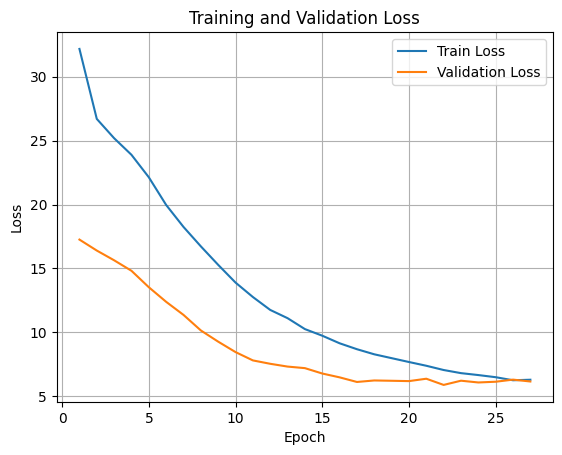

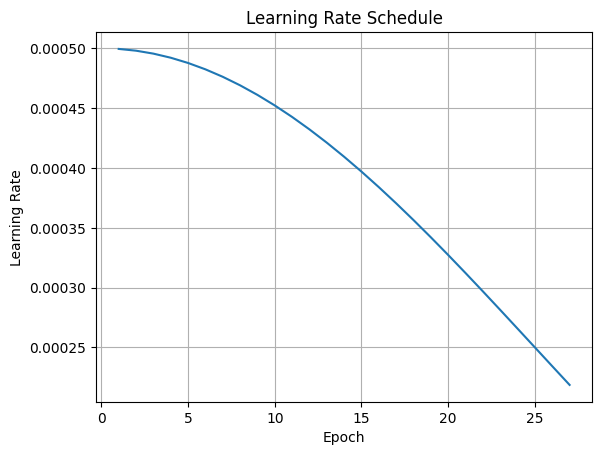

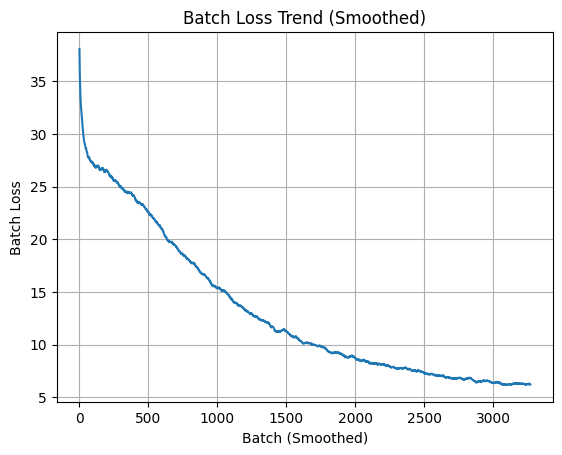

✅ Training history visualization complete.


In [55]:


import matplotlib.pyplot as plt
import numpy as np

def plot_training_history(history):
    """
    Visualize training history including:
    - Training loss
    - Validation loss
    - Learning rate
    - Batch loss trend
    """

    epochs = range(1, len(history.get("train_loss", [])) + 1)

    # --------- Plot Train & Validation Loss ---------
    plt.figure()
    if "train_loss" in history:
        plt.plot(epochs, history["train_loss"], label="Train Loss")
    if "val_loss" in history:
        plt.plot(epochs, history["val_loss"], label="Validation Loss")

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # --------- Plot Learning Rate ---------
    if "learning_rate" in history:
        plt.figure()
        plt.plot(epochs, history["learning_rate"])
        plt.xlabel("Epoch")
        plt.ylabel("Learning Rate")
        plt.title("Learning Rate Schedule")
        plt.grid(True)
        plt.show()

    # --------- Plot Batch Loss Trend (Smoothed) ---------
    if "batch_loss" in history and len(history["batch_loss"]) > 0:
        batch_losses = np.array(history["batch_loss"])

        # Smooth batch loss using moving average
        window = min(50, len(batch_losses))
        if window > 1:
            smoothed = np.convolve(batch_losses, np.ones(window)/window, mode="valid")
        else:
            smoothed = batch_losses

        plt.figure()
        plt.plot(smoothed)
        plt.xlabel("Batch (Smoothed)")
        plt.ylabel("Batch Loss")
        plt.title("Batch Loss Trend (Smoothed)")
        plt.grid(True)
        plt.show()

    print("✅ Training history visualization complete.")



plot_training_history(history)

Comprehensive Evaluation Metrics

In [66]:
# Cell: Model Evaluation (Multi-Label)

import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score

def evaluate_model(model, X_test, y_test, threshold=0.1, k=3):
    """
    Evaluate multi-label model performance.

    Metrics:
    - Micro F1
    - Macro F1
    - Precision
    - Recall
    - Precision@k
    - Recall@k
    """

    print("Running model evaluation...")

    # Get predictions
    y_pred_probs = model.predict(X_test, verbose=0)

    # Apply threshold
    y_pred_binary = (y_pred_probs >= threshold).astype(int)

    # -------- Standard Multi-Label Metrics --------
    micro_f1 = f1_score(y_test, y_pred_binary, average="micro", zero_division=0)
    macro_f1 = f1_score(y_test, y_pred_binary, average="macro", zero_division=0)

    precision = precision_score(y_test, y_pred_binary, average="micro", zero_division=0)
    recall = recall_score(y_test, y_pred_binary, average="micro", zero_division=0)

    # -------- Precision@k and Recall@k --------
    precision_at_k = []
    recall_at_k = []

    for i in range(len(y_test)):
        true_labels = np.where(y_test[i] == 1)[0]

        # Top-k predicted labels
        top_k = np.argsort(y_pred_probs[i])[-k:]

        if len(true_labels) == 0:
            continue

        correct = len(set(top_k) & set(true_labels))

        precision_at_k.append(correct / k)
        recall_at_k.append(correct / len(true_labels))

    avg_precision_at_k = np.mean(precision_at_k)
    avg_recall_at_k = np.mean(recall_at_k)

    # -------- Print Results --------
    print(" Evaluation Results:")
    print(f"  Micro F1:       {micro_f1:.4f}")
    print(f"  Macro F1:       {macro_f1:.4f}")
    print(f"  Precision:      {precision:.4f}")
    print(f"  Recall:         {recall:.4f}")
    print(f"  Precision@{k}:   {avg_precision_at_k:.4f}")
    print(f"  Recall@{k}:      {avg_recall_at_k:.4f}")

    results = {
        "micro_f1": micro_f1,
        "macro_f1": macro_f1,
        "precision": precision,
        "recall": recall,
        f"precision@{k}": avg_precision_at_k,
        f"recall@{k}": avg_recall_at_k,
    }

    return results

results = evaluate_model(model, X_val_out, y_val_out, threshold=0.5, k=10)

Running model evaluation...
 Evaluation Results:
  Micro F1:       0.6764
  Macro F1:       0.3382
  Precision:      0.8929
  Recall:         0.5444
  Precision@10:   0.4490
  Recall@10:      0.4264


In [67]:
#  (Dynamic k + Balanced Test Batch)
import numpy as np

def sample_balanced_test_batch(X_test, y_test, batch_size=1000):
    """Sample one example per label until batch_size (repo-style)."""
    u_labels, label_indices = get_unique_labels_filtered(y_test, exclude_tokens=[])
    if not u_labels:
        return X_test[:0], y_test[:0]
    labels = u_labels.copy()
    np.random.shuffle(labels)
    selected = []
    for label in labels:
        indices = label_indices[label]
        if indices:
            selected.append(np.random.choice(indices))
        if len(selected) >= batch_size:
            break
    selected = np.array(list(dict.fromkeys(selected)), dtype=int)
    return X_test[selected], y_test[selected]

def evaluate_model_dynamic_k(model, X_test, y_test, trained_labels=None, batch_size=1000):
    """Compute precision and recall with k = number of true labels (repo-style)."""
    X_batch, y_batch = sample_balanced_test_batch(X_test, y_test, batch_size=batch_size)
    if len(X_batch) == 0:
        print("No samples available for dynamic-k evaluation.")
        return {"precision_dynamic_k": 0.0, "recall_dynamic_k": 0.0}

    y_pred = model.predict(X_batch, verbose=0)
    precision_scores = []
    recall_scores = []

    trained_labels_set = set(trained_labels) if trained_labels is not None else None
    for i in range(len(y_batch)):
        true_labels = np.where(y_batch[i] == 1)[0]
        if trained_labels_set is not None:
            true_labels = [t for t in true_labels if t in trained_labels_set]
        if len(true_labels) == 0:
            continue
        k = len(true_labels)
        top_k = np.argsort(y_pred[i])[-k:]
        correct = len(set(top_k) & set(true_labels))
        precision_scores.append(correct / k)
        recall_scores.append(correct / len(true_labels))

    precision_dynamic_k = float(np.mean(precision_scores)) if precision_scores else 0.0
    recall_dynamic_k = float(np.mean(recall_scores)) if recall_scores else 0.0
    print(f"Precision@k (k = |true labels|): {precision_dynamic_k:.4f}")
    print(f" Recall@k (k = |true labels|): {recall_dynamic_k:.4f}")
    return {
        "precision_dynamic_k": precision_dynamic_k,
        "recall_dynamic_k": recall_dynamic_k
    }

dynamic_k_results = evaluate_model_dynamic_k(
    model, X_val_out, y_val_out, trained_labels=available_labels, batch_size=1000
)

Precision@k (k = |true labels|): 0.6145
 Recall@k (k = |true labels|): 0.6145


Low-Frequency Tool Evaluation

In [60]:
# Cell: Save Model and Metadata
import os
import json
import pickle

def save_model_and_metadata(model, vocab, class_weights, training_history, save_dir="Results"):
    """
    Save the trained transformer model along with vocabulary,
    class weights, and training history.
    """
    
    os.makedirs(save_dir, exist_ok=True)
    
    # 1️⃣ Save TensorFlow model
    model_path = os.path.join(save_dir, "transformer_model.h5")
    model.save(model_path, include_optimizer=True)
    print(f" Model saved to: {model_path}")
    
    # 2️⃣ Save vocabulary
    vocab_path = os.path.join(save_dir, "vocab.json")
    with open(vocab_path, "w") as f:
        json.dump(vocab, f)
    print(f" Vocabulary saved to: {vocab_path}")
    
    # 3️⃣ Save class weights
    class_weights_path = os.path.join(save_dir, "class_weights.pkl")
    with open(class_weights_path, "wb") as f:
        pickle.dump(class_weights, f)
    print(f"✅ Class weights saved to: {class_weights_path}")
    
    # 4️⃣ Save training history
    history_path = os.path.join(save_dir, "training_history.pkl")
    with open(history_path, "wb") as f:
        pickle.dump(training_history, f)
    print(f"✅ Training history saved to: {history_path}")
    
    print(f"🎯 All model artifacts saved in directory: {save_dir}")
    return save_dir
save_model_and_metadata(model, vocab, class_weights, history)


 Model saved to: Results/transformer_model.h5
 Vocabulary saved to: Results/vocab.json
✅ Class weights saved to: Results/class_weights.pkl
✅ Training history saved to: Results/training_history.pkl
🎯 All model artifacts saved in directory: Results


'Results'

In [23]:
# Cell: Save Processed Data
import os
import pickle

def save_processed_data(X_train, y_train, X_val, y_val, X_test, y_test,
                        label_to_indices, available_labels, reverse_vocab,
                        save_dir="processed_data"):
    """
    Save preprocessed data, label mappings, and reverse vocabulary
    for reproducible training and evaluation.
    """
    os.makedirs(save_dir, exist_ok=True)
    
    # Save train/val/test arrays
    np.save(os.path.join(save_dir, "X_train.npy"), X_train)
    np.save(os.path.join(save_dir, "y_train.npy"), y_train)
    np.save(os.path.join(save_dir, "X_val.npy"), X_val)
    np.save(os.path.join(save_dir, "y_val.npy"), y_val)
    np.save(os.path.join(save_dir, "X_test.npy"), X_test)
    np.save(os.path.join(save_dir, "y_test.npy"), y_test)
    
    # Save label_to_indices mapping
    with open(os.path.join(save_dir, "label_to_indices.pkl"), "wb") as f:
        pickle.dump(label_to_indices, f)
    
    # Save available labels list
    with open(os.path.join(save_dir, "available_labels.pkl"), "wb") as f:
        pickle.dump(available_labels, f)
    
    # Save reverse vocabulary
    with open(os.path.join(save_dir, "reverse_vocab.pkl"), "wb") as f:
        pickle.dump(reverse_vocab, f)
    
    print(f"✅ Processed data and mappings saved to {save_dir}")
    return save_dir
save_processed_data(X_train, y_train, X_val, y_val, X_test, y_test,
                        label_to_indices, available_labels, reverse_vocab)

✅ Processed data and mappings saved to processed_data


'processed_data'

Tool Recommendation Interface

In [61]:
# Cell 19: Interactive Tool Recommendation Function
def recommend_next_tools(context_tools, vocab, reverse_vocab, model, top_k=5, max_len=MAX_LEN):
    """Recommend next tools given context"""

    def clean_and_encode_tool(tool_name):
        """Clean and encode single tool"""
        cleaned_tool = clean_tool_id(tool_name)
        return vocab.get(cleaned_tool, vocab["<UNK>"])

    if isinstance(context_tools, str):
        context_tools = [tool.strip() for tool in context_tools.split(",")]

    encoded_context = [clean_and_encode_tool(tool) for tool in context_tools]

    if len(encoded_context) < max_len:
        encoded_context = [vocab["<PAD>"]] * (max_len - len(encoded_context)) + encoded_context
    else:
        encoded_context = encoded_context[-max_len:]

    input_tensor = np.array([encoded_context])
    predictions = model.predict(input_tensor, verbose=0)[0]

    top_k_indices = np.argsort(predictions)[-top_k:][::-1]

    recommendations = []
    for idx in top_k_indices:
        tool_name = reverse_vocab.get(idx, "<UNK>")
        confidence = float(predictions[idx])
        recommendations.append({
            "tool": tool_name,
            "confidence": confidence,
            "tool_index": idx
        })

    return recommendations

# Example usage
print("Tool Recommendation Interface:")
print("=" * 50)

example_context_1 = ["tool_3d54e34c"]
recommendations_1 = recommend_next_tools(example_context_1, vocab, reverse_vocab, model, top_k=10)

print(f"\nExample 1 - Context: {example_context_1}")
print("Top 10 Recommendations:")
for i, rec in enumerate(recommendations_1, 1):
    print(f"  {i:2d}. {rec['tool']:<20} (confidence: {rec['confidence']:.4f})")

example_context_2 = ["tool_3d54e34c", "tool_80adb2020"]
recommendations_2 = recommend_next_tools(example_context_2, vocab, reverse_vocab, model, top_k=10)

print(f"\nExample 2 - Context: {example_context_2}")
print("Top 10 Recommendations:")
for i, rec in enumerate(recommendations_2, 1):
    print(f"  {i:2d}. {rec['tool']:<20} (confidence: {rec['confidence']:.4f})")

Tool Recommendation Interface:

Example 1 - Context: ['tool_3d54e34c']
Top 10 Recommendations:
   1. <UNK>                (confidence: 0.2332)
   2. mothur_summary_seqs  (confidence: 0.2289)
   3. multiqc              (confidence: 0.2234)
   4. filter_from_file     (confidence: 0.1976)
   5. collapse_dataset     (confidence: 0.1875)
   6. bwa_mem              (confidence: 0.1870)
   7. tp_sed_tool          (confidence: 0.1866)
   8. relabel_from_file    (confidence: 0.1784)
   9. cut1                 (confidence: 0.1761)
  10. mothur_make_shared   (confidence: 0.1757)

Example 2 - Context: ['tool_3d54e34c', 'tool_80adb2020']
Top 10 Recommendations:
   1. <UNK>                (confidence: 0.2357)
   2. mothur_summary_seqs  (confidence: 0.2349)
   3. multiqc              (confidence: 0.2224)
   4. filter_from_file     (confidence: 0.1971)
   5. tp_sed_tool          (confidence: 0.1866)
   6. collapse_dataset     (confidence: 0.1862)
   7. bwa_mem              (confidence: 0.1855)
   8. m